# __Option Génomique Bioinformatique :__

## __Session 1 "Axe 1 : Visualiation des gènes différentiellement exprimés et analyses d'enrichissement"__
Claire Vandiedonck & Sandrine Caburet
***

**Tutorial**

In this tutorial, we will further analyse the Differential Expression between T1D patients and their related unaffected controls using microarrays transcriptome data ("Fil Rouge" UE5 and Practical Sessions in UE1).

We will first load the data and metadata.

We will also use two powerful packages:

- `ComplexHeatMap` to generate enhanced heatmaps: with sample annotations on the sides, with hierarchical clustering dendograms generated with several distance metrics and clusterization aggregration methods

- `clusteProfiler` to perform further enrichment analyses on sets of genes of interest

We will finally prepare input files for `GSEA: Gene Set Enrichment Analysis` with the GSEA Java stand-alone application.



**Avant d'aller plus loin**

<div class="alert alert-block alert-danger"><b>Attention:</b> 
Ne travaillez pas directement sur ce notebook pour ne pas le perdre. Dupliquez-le et renommez-le par exemple en ajoutant vos initiales et travaillez sur cette nouvelle copie. Pour ce faire, dans le panneau de gauche, faites un clic droit sur le fichier et sélectionnez "Duplicate". Puis, toujours dans la colonne de gauche, faites un clic droit sur cette copie et sélectionnez "rename" pour changer le nom. Ouvrez ensuite cette nouvelle version en double cliquant dessus. Vous êtes prêt(e) à démarrer! <br>
<br>
<b>N'oubliez pas de sauvegarder régulièrement votre notebook</b>: <kbd>Ctrl</kbd> + <kbd>S</kbd>. ou en cliquant sur l'icone 💾 en haut à gauche de votre notebook ou dans le Menu du JupyterLab "File puis "Save Notebook"! Vous pouvez aussi le sauvegarder au format html: Menu "File" > Export Notebook As> Export notebook as HTML.
</div>

## 0. Set up parameters and RSession
---

We start with setting up paths to directories.

In [7]:
# Code cell n°1

#setwd("~/meg_m1_gb_r")
myworking_path <- "./" # modify as necessary
datapath <- "/srv/data/meg-m1-gb/DGE_results/"

We install required libraries and load them.

In [8]:
# Code cell n°2

# list the required libraries
requiredLib <- c(
    "statmod",
    "RColorBrewer",
    "dendextend",
    "stats",
    "grDevices",
    "BiocManager",
    "writexl",
    "ggnewscale",
    "ggupset",
    "writexl",
    "readxl",
    "ggridges",
    "gplots")
requiredBiocLib <- c("limma", 
                     "org.Hs.eg.db",
                     "clusterProfiler",
                     "enrichplot",
                     "ComplexHeatmap",
                     "ReactomePA")

# install required libraries if not
for (lib in requiredLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
    install.packages(lib, quiet = TRUE)
  }
}

for( lib in requiredBiocLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
  BiocManager::install(lib, quiet = TRUE)
  }
}

# load libraries
message("Loading required libraries")
for (lib in requiredLib) {
  library(lib, character.only = TRUE)}

for (lib in requiredBiocLib) {
  library(lib, character.only = TRUE)}

# kepp tracks of R and packages for this study
sessionInfo()

rm(lib, requiredLib, requiredBiocLib)

Loading required libraries



R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /srv/conda/envs/notebook/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ReactomePA_1.38.0     ComplexHeatmap_2.10.0 enrichplot_1.14.2    
 [4] clusterProfiler_4.2.2 org.Hs.eg.db_3.14.0   AnnotationDbi_1.56.2 
 [7] IRanges_2.28.0        S4Vectors_0.32.4      Biobase_2.54.0       
[10] BiocGenerics_0.40.0   limma_3.50.3          gplots_3.1.3         
[13] gg

## 1. Load Data
---

At the end of the Fil Rouge on microarrays, we ended up with several R objects that we will reload in this R Session:

### 1.A. Metadata

- probes

In [9]:
# Code cell n°3

load(paste(datapath,"probes.RData",sep = ""))
ls()
str(probes)
gene_list <- probes$TargetID
cat("There are ", length(unique(gene_list)), "unique genes\n")

[1] "datapath"       "gene_list"      "myworking_path" "norm.quant"    
[5] "probes"         "samples_info"

'data.frame':	47323 obs. of  9 variables:
 $ ProbeID              : int  6450255 2570615 6370619 2600039 2650615 5340672 2000519 3870044 7050209 1580181 ...
 $ CHROMOSOME           : chr  "7" "19" "19" "10" ...
 $ CYTOBAND             : chr  "7p15.3e" "19q13.43c" "19q13.43c" "10q11.23c" ...
 $ PROBE_CHR_ORIENTATION: chr  "-" "-" "-" "-" ...
 $ PROBE_COORDINATES    : chr  "20147187-20147236" "63548541-63548590" "63549180-63549229" "52566586-52566635" ...
 $ REFSEQ_ID            : chr  "NM_182762.2" "NM_130786.2" "NM_130786.2" "NM_138932.1" ...
 $ ENTREZ_GENE_ID       : int  346389 1 1 29974 29974 29974 23784 23784 23784 54715 ...
 $ TargetID             : chr  "7A5" "A1BG" "A1BG" "A1CF" ...
 $ SYMBOL               : chr  "7A5" "A1BG" "A1BG" "A1CF" ...
There are  34694 unique genes


- samples information (ID, pedigree ID, sex, age, status, stimulation level...)

In [10]:
# Code cell n°4

load(paste(datapath,"samples_info.RData", sep = ""))
ls()
str(samples_info)

[1] "datapath"       "gene_list"      "myworking_path" "norm.quant"    
[5] "probes"         "samples_info"

'data.frame':	264 obs. of  8 variables:
 $ array.labels: chr  "5753669129_B" "5753669129_C" "5753669129_E" "5753669129_K" ...
 $ PedID       : chr  "1" "1" "1" "1" ...
 $ ID          : chr  "1" "1" "1" "1" ...
 $ Status      : chr  "2" "2" "2" "2" ...
 $ Stim        : chr  "0" "0" "6" "6" ...
 $ Full        : chr  "1_1_2_0" "1_1_2_0" "1_1_2_6" "1_1_2_6" ...
 $ Sex         : chr  "1" "1" "1" "1" ...
 $ Age         : int  10 10 10 10 10 10 18 18 18 18 ...


### 1.B. Normalized expression data

We load the `norm.quant` object obtained after log2 transformation and between-samples quantile normalization.

In [11]:
# Code cell n°5

load(paste(datapath, "norm.quant.RData", sep = ""))
ls()
str(norm.quant)
norm.quant[1:10, 1:10]

[1] "datapath"       "gene_list"      "myworking_path" "norm.quant"    
[5] "probes"         "samples_info"

 num [1:47323, 1:264] 7.35 7.09 6.3 6.57 6.49 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:47323] "6450255" "2570615" "6370619" "2600039" ...
  ..$ : chr [1:264] "5753669129_B" "5753669129_C" "5753669129_E" "5753669129_K" ...


,5753669129_B,5753669129_C,5753669129_E,5753669129_K,5753669129_A,5753669129_F,5753669095_B,5753669095_F,5753669095_G,5753669095_K
6450255,7.351549,7.056063,7.052947,7.398073,7.223727,6.866752,7.019286,6.986984,7.289715,7.082987
2570615,7.087770,6.909035,6.874572,6.794254,6.635361,6.766837,6.650753,6.841188,6.816850,6.684924
6370619,6.299524,6.754202,6.550678,6.574270,6.625025,6.473627,6.401915,6.318659,6.461961,6.427141
2600039,6.572519,6.609202,6.568940,6.391801,6.435965,6.782794,6.468696,6.537351,6.494413,6.615691
2650615,6.492314,6.494968,6.773884,6.507731,6.935357,6.428773,6.606865,6.618028,6.434543,6.448600
5340672,6.194034,6.138695,6.069135,6.192778,6.247462,6.235562,5.909282,6.065657,6.056266,6.199995
2000519,6.717292,6.453334,6.883398,6.958528,6.913643,6.357944,6.649513,6.774690,6.485854,6.731937
3870044,5.894237,5.753032,5.981951,5.991817,5.744194,5.728102,5.842047,5.699204,5.672224,5.871414
7050209,6.733664,6.699775,6.569374,6.527873,6.850950,6.769487,6.569142,6.539663,6.786768,6.549867
1580181,6.740298,6.402660,6.329971,6.402146,6.536189,6.628187,6.624250,6.416259,6.415431,6.628095


Each row corresponds to an Illumina probeID (probe Sets), while each column name corresponds to an Illumina array sample.
The correspondance between probeID and gene names is provided in the `probes` object, while the experimental design matrix of samples is provided in the `samples_info` object.

### 1.C. Results of the DGE analysis

- At the end of the DGE analysis, we stored all results in a list `limma.full.outs` with **6 dataframes**:

        1. with the result of the full model analysis: testing whether gene expression varies in at least one condition

        2. with the result of the first contrast for the DGE analysis

        3. etc...

We saved this list in an excel document `DGE_T1D_microarrays.xlsx`, each tab corresponding to one list element (i.e. one tab corresponding to one analysis).

- Here we upload the data and put them back in a list R object, using a `Read Excel` function.

In [12]:
# Code cell n°6

limma.full.outs <- list()

sheet_names <- readxl::excel_sheets(paste(datapath, "DGE_T1D_microarrays.xlsx", sep = ""))

for (sheet in sheet_names) {
limma.full.outs[[sheet]] <- as.data.frame(read_xlsx(paste(datapath, "DGE_T1D_microarrays.xlsx", sep = ""), sheet = sheet))
    }

In [13]:
?read_xlsx

read_excel {readxl},R Documentation
path,Path to the xls/xlsx file.
sheet,"Sheet to read. Either a string (the name of a sheet), or an integer (the position of the sheet). Ignored if the sheet is specified via range. If neither argument specifies the sheet, defaults to the first sheet."
range,"A cell range to read from, as described in cell-specification. Includes typical Excel ranges like ""B3:D87"", possibly including the sheet name like ""Budget!B2:G14"", and more. Interpreted strictly, even if the range forces the inclusion of leading or trailing empty rows or columns. Takes precedence over skip, n_max and sheet."
col_names,"TRUE to use the first row as column names, FALSE to get default names, or a character vector giving a name for each column. If user provides col_types as a vector, col_names can have one entry per column, i.e. have the same length as col_types, or one entry per unskipped column."
col_types,"Either NULL to guess all from the spreadsheet or a character vector containing one entry per column from these options: ""skip"", ""guess"", ""logical"", ""numeric"", ""date"", ""text"" or ""list"". If exactly one col_type is specified, it will be recycled. The content of a cell in a skipped column is never read and that column will not appear in the data frame output. A list cell loads a column as a list of length 1 vectors, which are typed using the type guessing logic from col_types = NULL, but on a cell-by-cell basis."
na,"Character vector of strings to interpret as missing values. By default, readxl treats blank cells as missing data."
trim_ws,Should leading and trailing whitespace be trimmed?
skip,"Minimum number of rows to skip before reading anything, be it column names or data. Leading empty rows are automatically skipped, so this is a lower bound. Ignored if range is given."
n_max,"Maximum number of data rows to read. Trailing empty rows are automatically skipped, so this is an upper bound on the number of rows in the returned tibble. Ignored if range is given."
guess_max,Maximum number of data rows to use for guessing column types.


This list contains the following 6 dataframes:

In [14]:
# Code cell n°7

print(names(limma.full.outs))

[1] "limma.fullmodel.out" "limma.Pat.H0.out"    "limma.Pat.H24.out"  
[4] "limma.Pat.H6.out"    "limma.Pat.H624.out"  "limma.Pat.out"      


- We can check the structure of the full model:

In [15]:
# Code cell n°8

str(limma.full.outs[[1]])

'data.frame':	47323 obs. of  18 variables:
 $ ProbeID              : chr  "3120474" "3310376" "630725" "1430709" ...
 $ Pat.H0               : num  -0.58 0.327 -0.569 -0.285 0.328 ...
 $ Pat.H6               : num  0.1486 0.0132 -0.2268 -0.0714 0.0257 ...
 $ Pat.H24              : num  0.00847 -0.07835 -0.1993 -0.35116 0.16611 ...
 $ Pat.H6H24            : num  0.1571 -0.0652 -0.4261 -0.4226 0.1918 ...
 $ Patient              : num  -1.583 0.915 -2.133 -1.277 1.175 ...
 $ AveExpr              : num  7.81 11.45 7.92 6.97 7.27 ...
 $ F                    : num  21.6 17 14.2 14 13.9 ...
 $ P.Value              : num  1.55e-12 3.86e-10 1.29e-08 1.64e-08 1.83e-08 ...
 $ adj.P.Val            : num  7.34e-08 9.14e-06 1.60e-04 1.60e-04 1.60e-04 ...
 $ CHROMOSOME           : chr  "22" "11" "12" "17" ...
 $ CYTOBAND             : chr  "22q11.23c" "11q12.1a" "12q15a" "17q11.2e" ...
 $ PROBE_CHR_ORIENTATION: chr  "+" "-" "-" "+" ...
 $ PROBE_COORDINATES    : chr  "23923092-23923141" "57296016-5729

We have the log2 mean expression per condition, followed by the average expression in all conditions, then the statistic value F and the corresponding P.Val and adj.P.Val after Benjamini-Hochberg correction. Then you have probes annotations.

- Finally, we can check the structure of any contrast results, like below, or the contrast between Patients and Controls, whatever the stimulation:

In [16]:
# Code cell n°9

str(limma.full.outs[[6]])

'data.frame':	47323 obs. of  17 variables:
 $ ProbeID              : chr  "3120474" "3310376" "630725" "6280440" ...
 $ logFC                : num  -1.583 0.915 -2.133 1.175 0.665 ...
 $ CI.L                 : num  -1.979 0.657 -2.797 0.799 0.449 ...
 $ CI.R                 : num  -1.186 1.174 -1.47 1.551 0.882 ...
 $ AveExpr              : num  7.81 11.45 7.92 7.27 7.86 ...
 $ t                    : num  -7.86 6.97 -6.33 6.15 6.04 ...
 $ P.Value              : num  9.51e-14 2.48e-11 1.02e-09 2.86e-09 5.02e-09 ...
 $ adj.P.Val            : num  4.50e-09 5.86e-07 1.62e-05 3.39e-05 4.75e-05 ...
 $ B                    : num  20 14.9 11.5 10.6 10.1 ...
 $ CHROMOSOME           : chr  "22" "11" "12" "22" ...
 $ CYTOBAND             : chr  "22q11.23c" "11q12.1a" "12q15a" "22q13.2c" ...
 $ PROBE_CHR_ORIENTATION: chr  "+" "-" "-" "+" ...
 $ PROBE_COORDINATES    : chr  "23923092-23923141" "57296016-57296065" "68548736-68548785" "41855291-41855340" ...
 $ REFSEQ_ID            : chr  "XM_371461.4

We have the log2 Fold Change between the two conditions (here log2(Pat) - log2(Cont)), with its confidence interval, followed by the average expression in both conditions, then the statistic value t, the P.Value and adj.P.Val after Benjamini-Hochberg correction and the B statiscics (the one used for pvalue). Then you have probe annotations.

## 2. Enhanced heatmaps with `ComplexHeatmap`
---

There are two main packages to draw enhanced heatmaps:
- [pheatmap](https://cran.r-project.org/web/packages/pheatmap/index.html): a CRAN packages.
- [ComplexHeatmap](https://jokergoo.github.io/ComplexHeatmap-reference/book/) on GitHub but also available in Bioconductor, the second generation of pheatmap.

ComplexHeatmap is the most flexible tool to draw heatmaps with a lot of options, notably to add annotations.

Below is presented a quick example on ComplexHeatmap usage.

- Let's first take an output from limma DGE analysis, for example with the full model and the 34 differentially expressed genes. We will save it in a matrix format beacause ComplexHeatmap works with matrices.

In [17]:
# Code cell n°10

probes_sig <- subset(limma.full.outs$limma.fullmodel.out, adj.P.Val < 0.01 )[, "ProbeID"]
length(probes_sig)
mat_full <- norm.quant[row.names(norm.quant) %in% probes_sig,]
str(mat_full)
colnames(mat_full) <- samples_info$Status
row.names(mat_full) <- probes$TargetID[probes$ProbeID %in% probes_sig]

[1] 34

 num [1:34, 1:264] 7.84 7.41 7.54 10.67 9.16 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:34] "1820347" "6280440" "2510546" "6650079" ...
  ..$ : chr [1:264] "5753669129_B" "5753669129_C" "5753669129_E" "5753669129_K" ...


- In limma, the `coolmap()` function could draw a simple heatmap : 

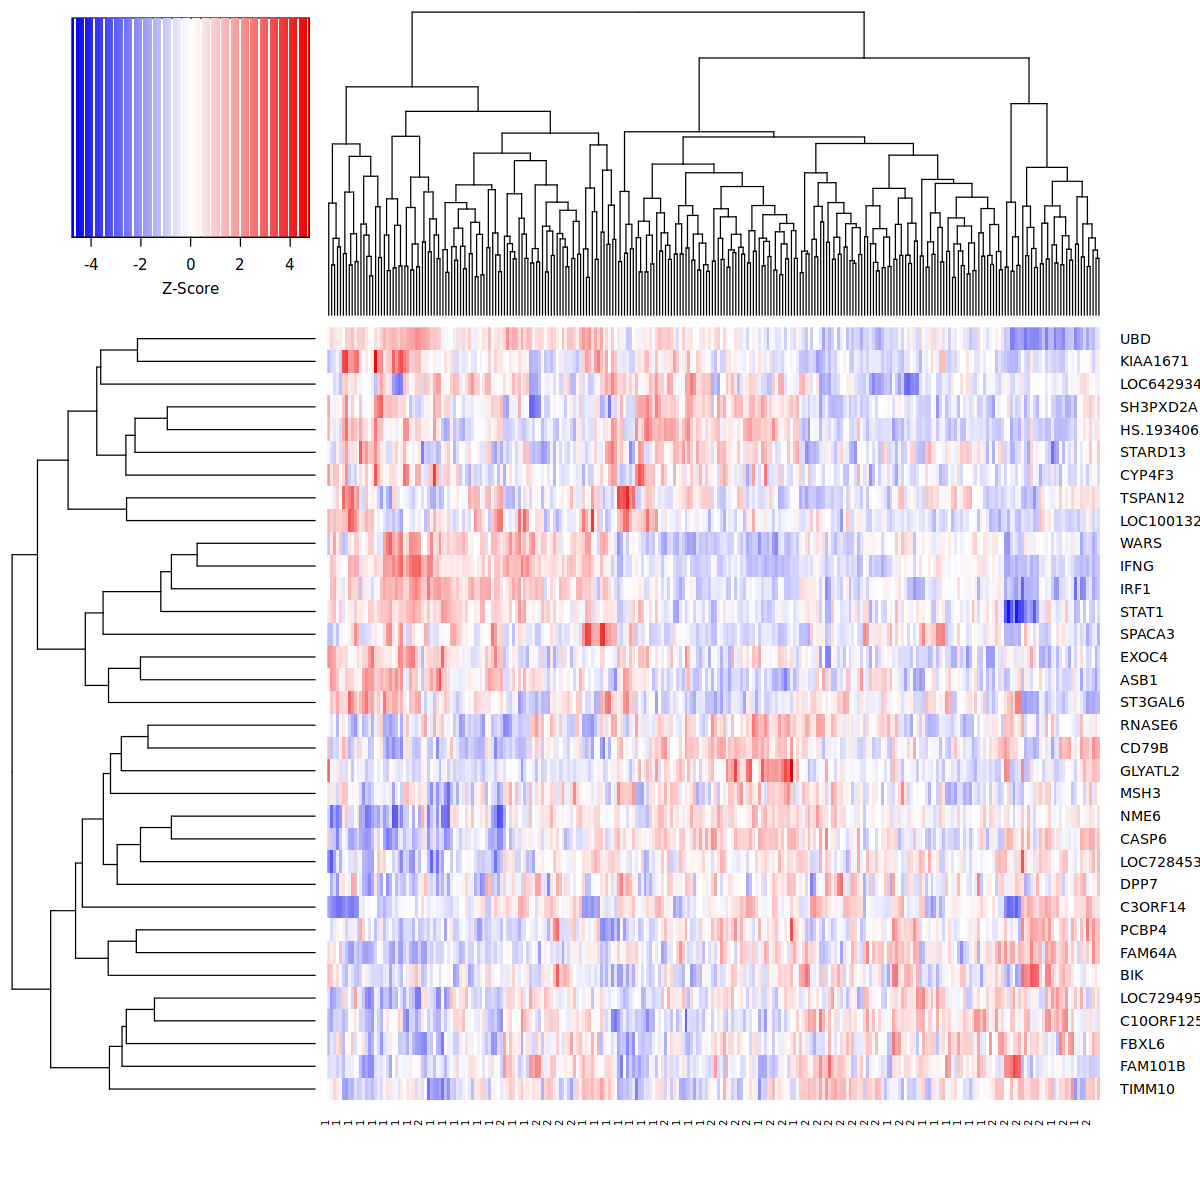

In [18]:
# Code cell n°11
options(repr.plot.width = 10, repr.plot.height = 10)
limma::coolmap(mat_full, col = "redblue",cexCol = 0.6)

- To use ComplexHeatmap, the dataset must be a **matrix** with samples in columns and genes in rows. We thus transpose our matrix `mat_full`.

- In addition, we use the function `scale()` to **center our data with a Z score**:

In [19]:
# Code cell n°12

tmat_full <- t(apply(mat_full, 1, scale))

- Then you select a **distance** for the similarity between samples. It can be a pre-defined character which is in ("euclidean", "maximum", "manhattan", "canberra", "binary", 
"minkowski", "pearson", "spearman", "kendall"). Default is "euclidean". It can also be a function. In R the function to compute distances is `dist()`. The correlation distance is defined as 1 - cor(x, y, method). [See there](https://jokergoo.github.io/ComplexHeatmap-reference/book/a-single-heatmap.html#distance-methods) for further details.

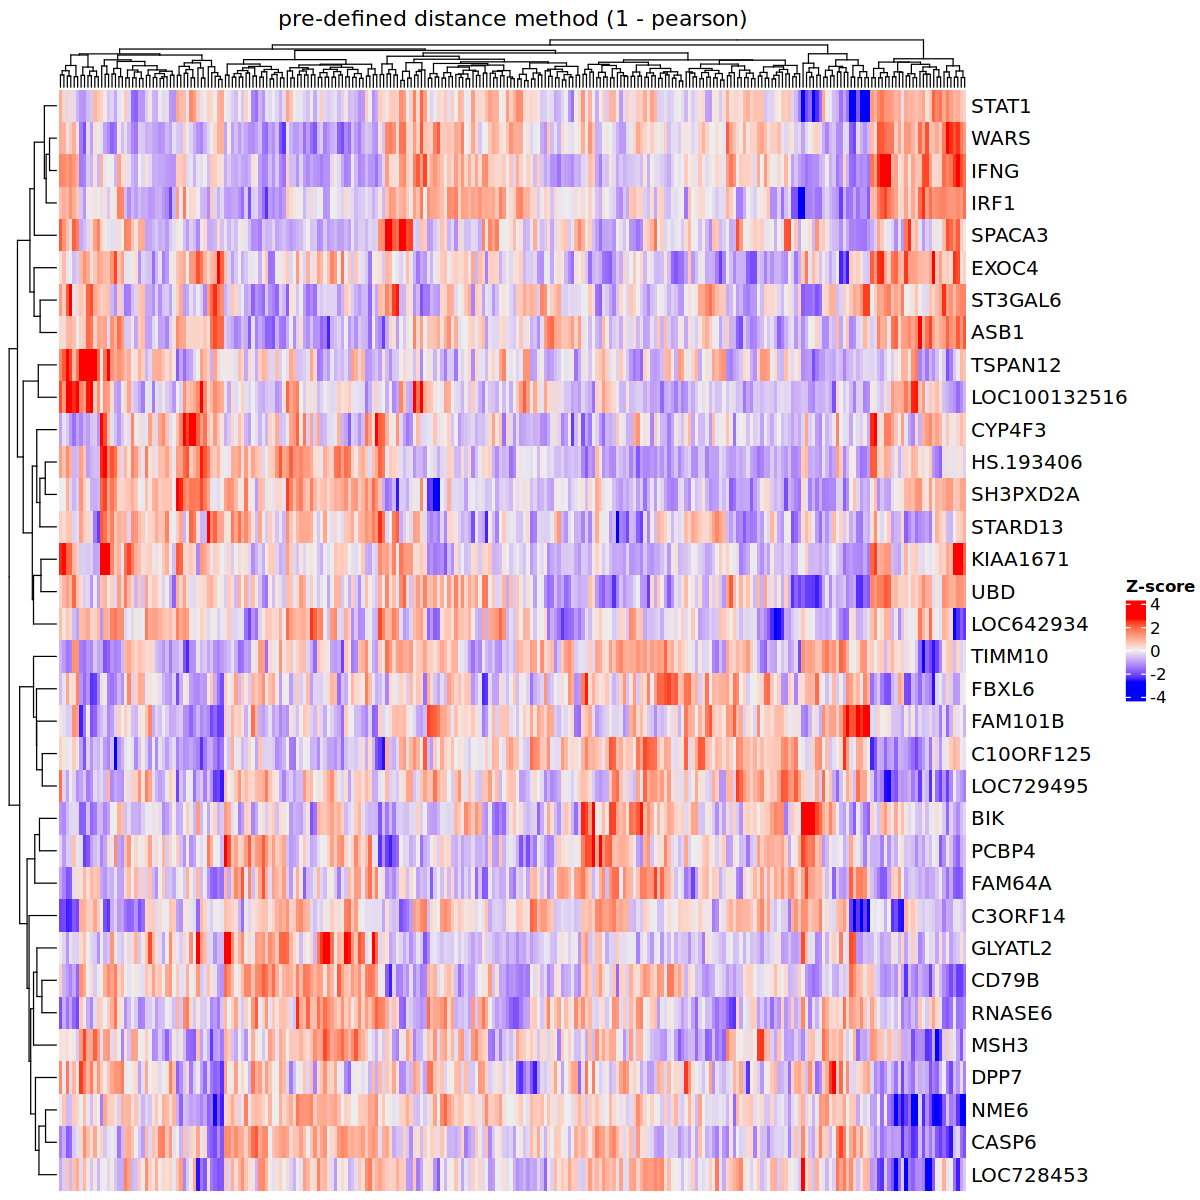

In [20]:
# Code cell n°13

ComplexHeatmap::Heatmap(tmat_full,
                        name = "Z-score",
                        clustering_distance_rows = "pearson",
                        column_title = "pre-defined distance method (1 - pearson)")

- You can also select the **clustering method** by `clustering_method_rows` and `clustering_method_columns`. Possible methods are those supported in `hclust()` function: "ward.D", "ward.D2", "single", "complete", "average" (= UPGMA), "mcquitty" (= WPGMA), "median" (= WPGMC) or "centroid" (= UPGMC).

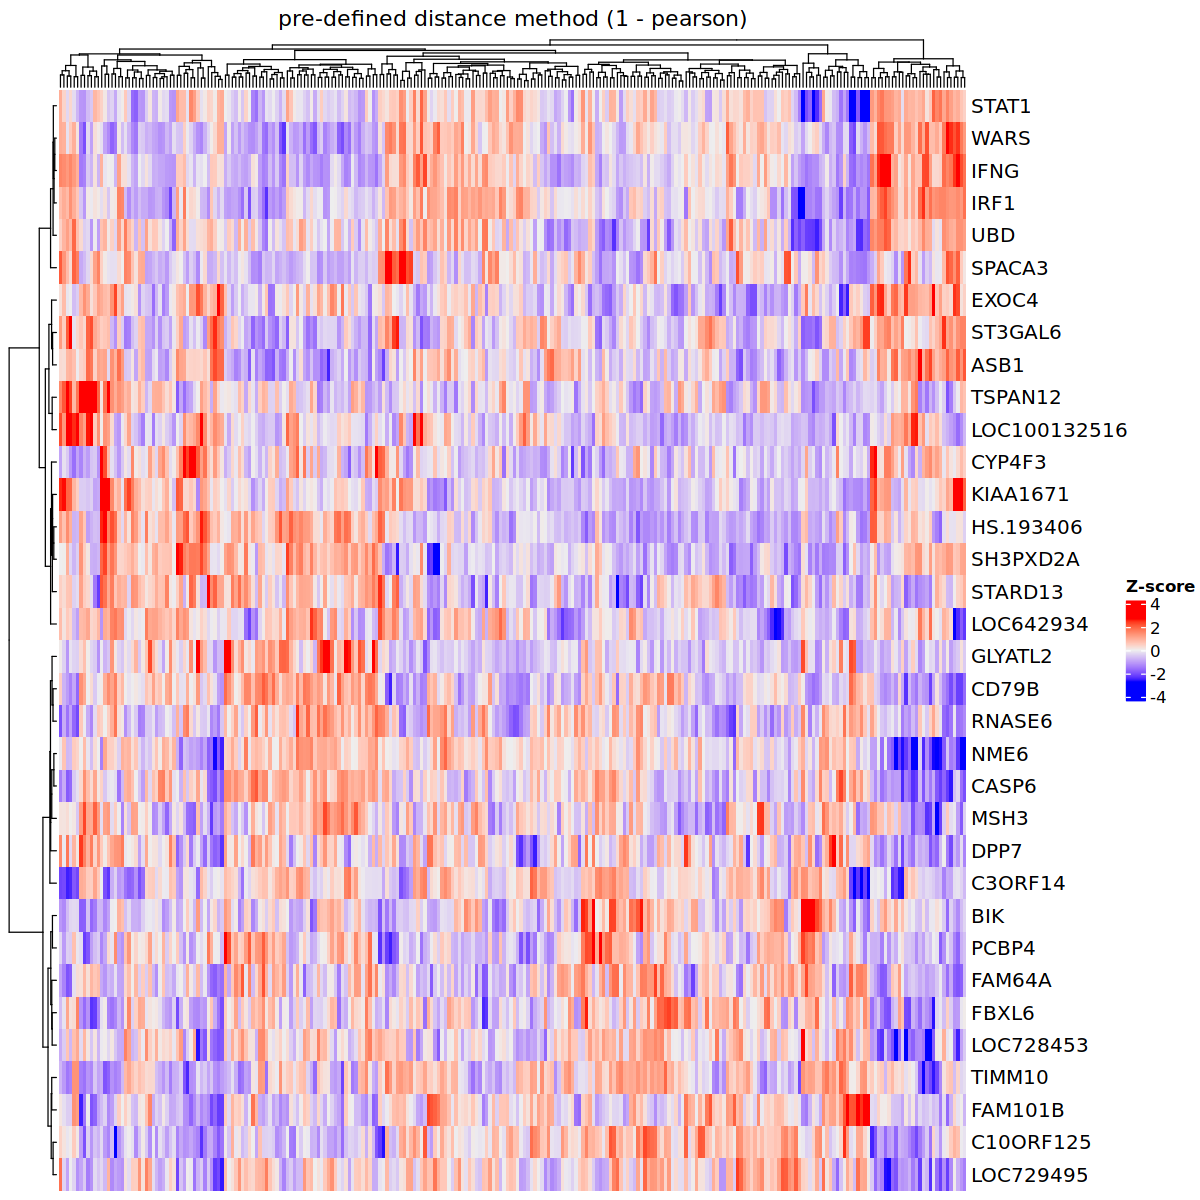

In [21]:
# Code cell n°14

ComplexHeatmap::Heatmap(tmat_full,
                        name = "Z-score",
                        clustering_distance_rows = "pearson",
                        column_title = "pre-defined distance method (1 - pearson)",
                        clustering_method_rows = "ward.D")

- One nice usage of ComplexHeatmap is the possibility to add custom **annotations**: `ha` for "heatmap annotation" is the object name used in ComplexHeatmap tutorial.

    - You can add annotations on samples, either quantitative with the fundtion `anno_points()` or `anno_barplot()` or qualitative with a dataframe. The `col` argument is used to specify the colors of the different categorical values. For the quantitative values, you can add points or boxplots for example.

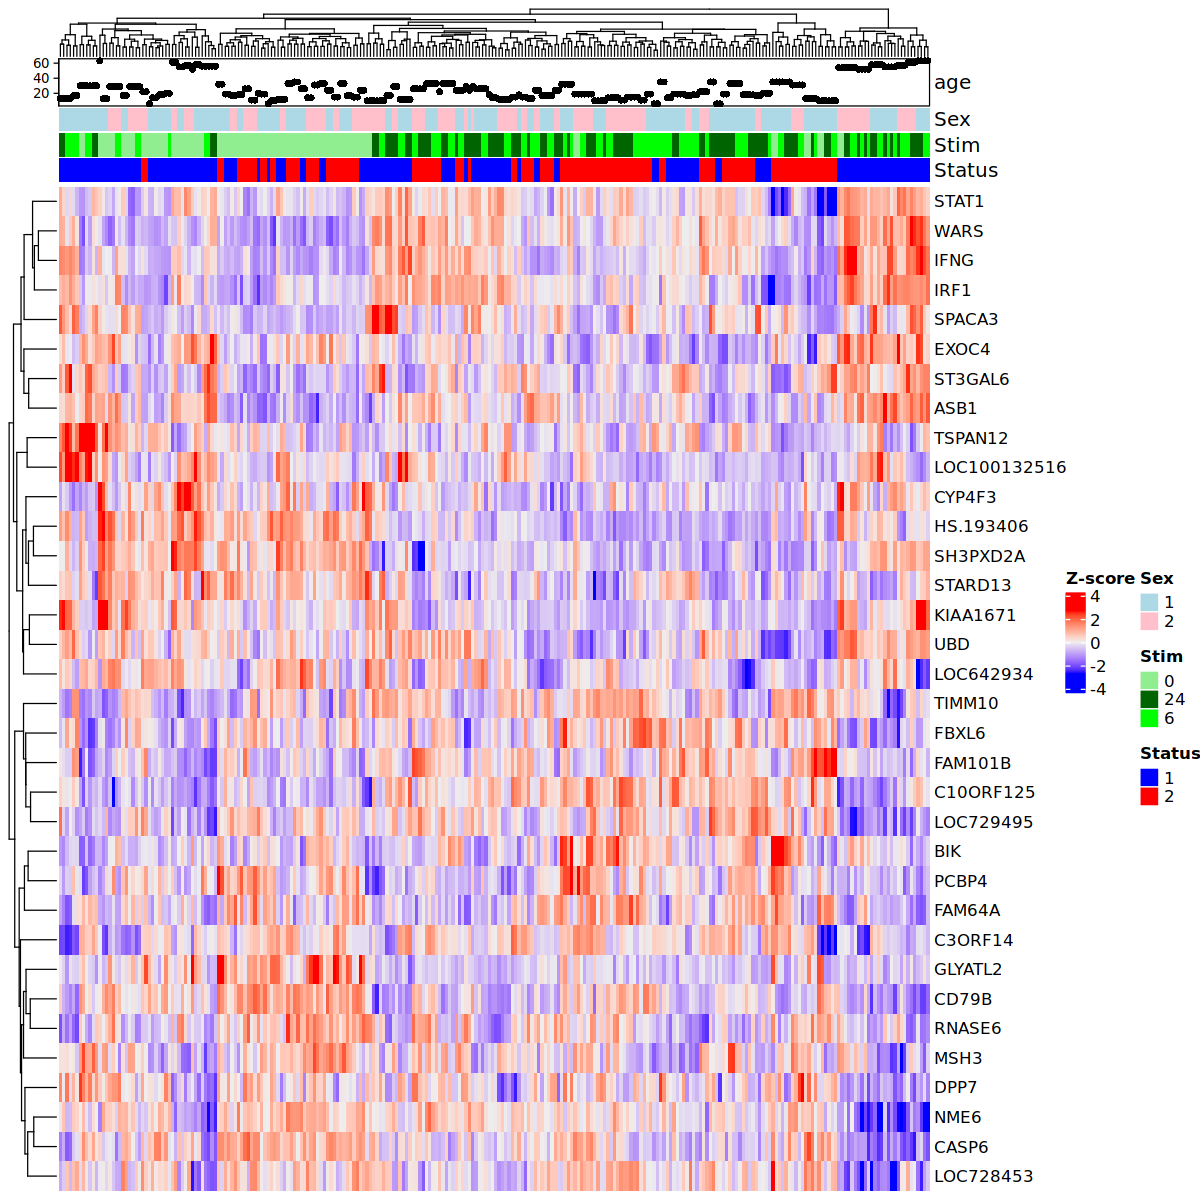

In [22]:
# Code cell n°15

ha <- HeatmapAnnotation(age = anno_points(samples_info$Age),
                        df = data.frame(Sex = samples_info$Sex,
                                        Stim = samples_info$Stim,
                                        Status = samples_info$Status),
                        col = list(Status = c("1" = "blue", "2" = "red"),
                                   Stim = c("0" = "lightgreen", "6"= "green", "24" = "darkgreen"),
                                   Sex = c("1" = "lightblue", "2" = "pink"))
                        )
ComplexHeatmap::Heatmap(tmat_full,
                        name = "Z-score",
                        top_annotation = ha,
                        row_names_gp = gpar(fontsize = 10)
                       )

Below is another example without clustering the samples, saving the plot in an R object then drawing the heatmap with the `draw()` function.

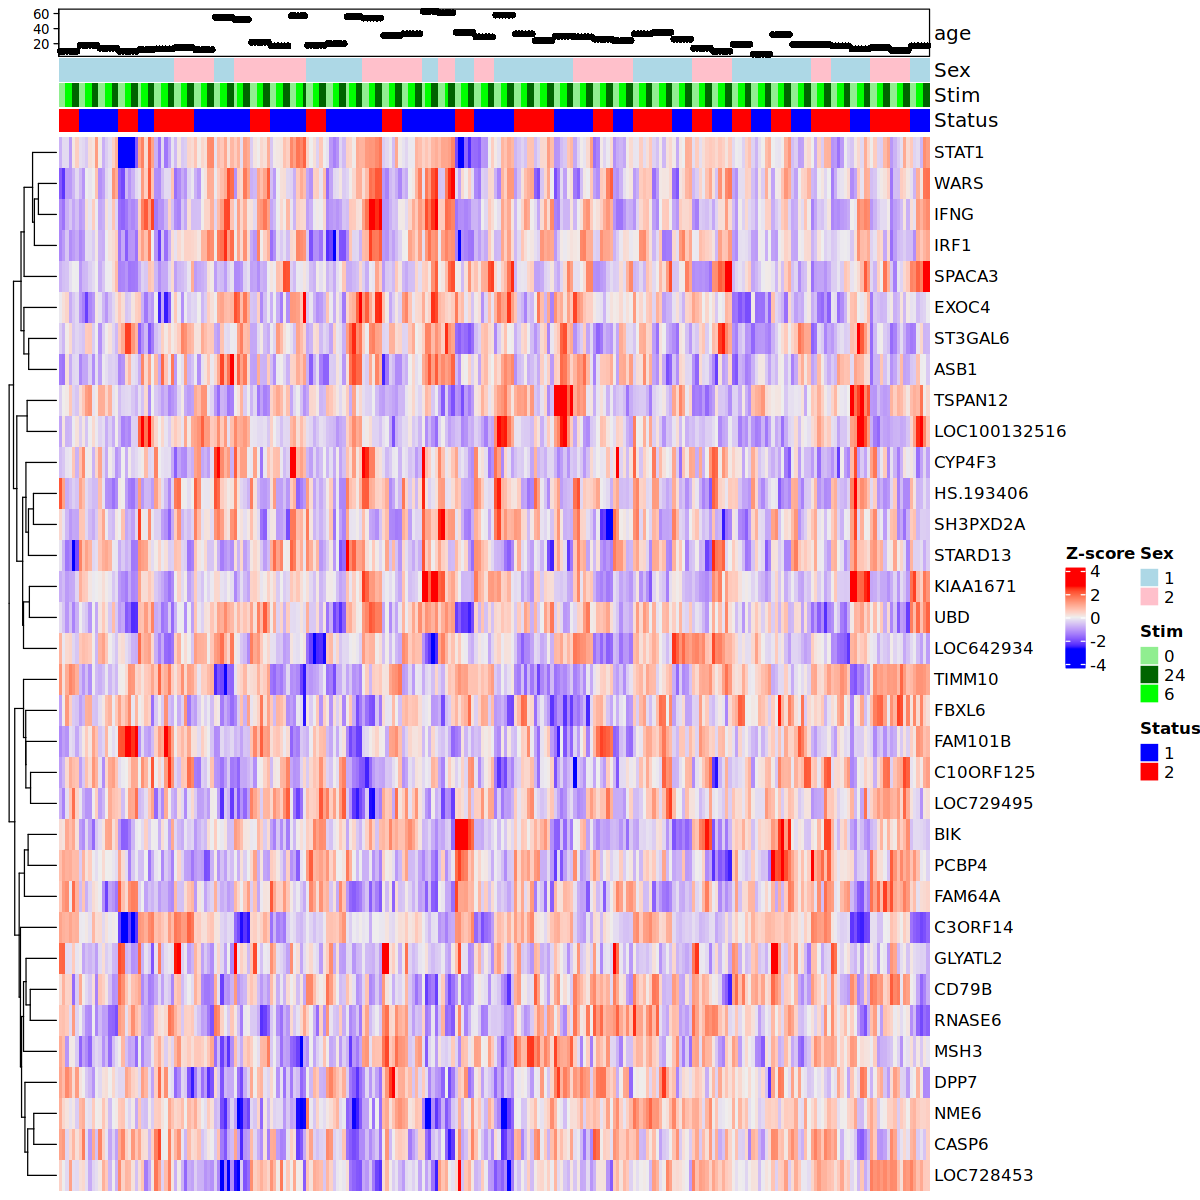

In [23]:
# Code cell n°16

h_tx <- ComplexHeatmap::Heatmap(tmat_full,
                                name = "Z-score",
                                top_annotation = ha,
                                row_names_gp = gpar(fontsize = 10),
                                cluster_columns = FALSE)

ComplexHeatmap::draw(h_tx)

You could also add annotations to genes: adding gene level expression for example (see next example), or coloring genes given gene sets.

In [24]:
# Code cell n°17

ha_col <- columnAnnotation(age = anno_points(samples_info$Age),
                        df = data.frame(Sex = samples_info$Sex,
                                        Stim = samples_info$Stim,
                                        Status = samples_info$Status),
                        col = list(Status = c("1" = "blue", "2" = "red"),
                                   Stim = c("0" = "lightgreen", "6"= "green", "24" = "darkgreen"),
                                   Sex = c("1" = "lightblue", "2" = "pink"))
                        )

ha_row <- rowAnnotation(mean_expr = anno_points(subset(limma.full.outs$limma.fullmodel.out, adj.P.Val < 0.01 )$AveExpr)
)

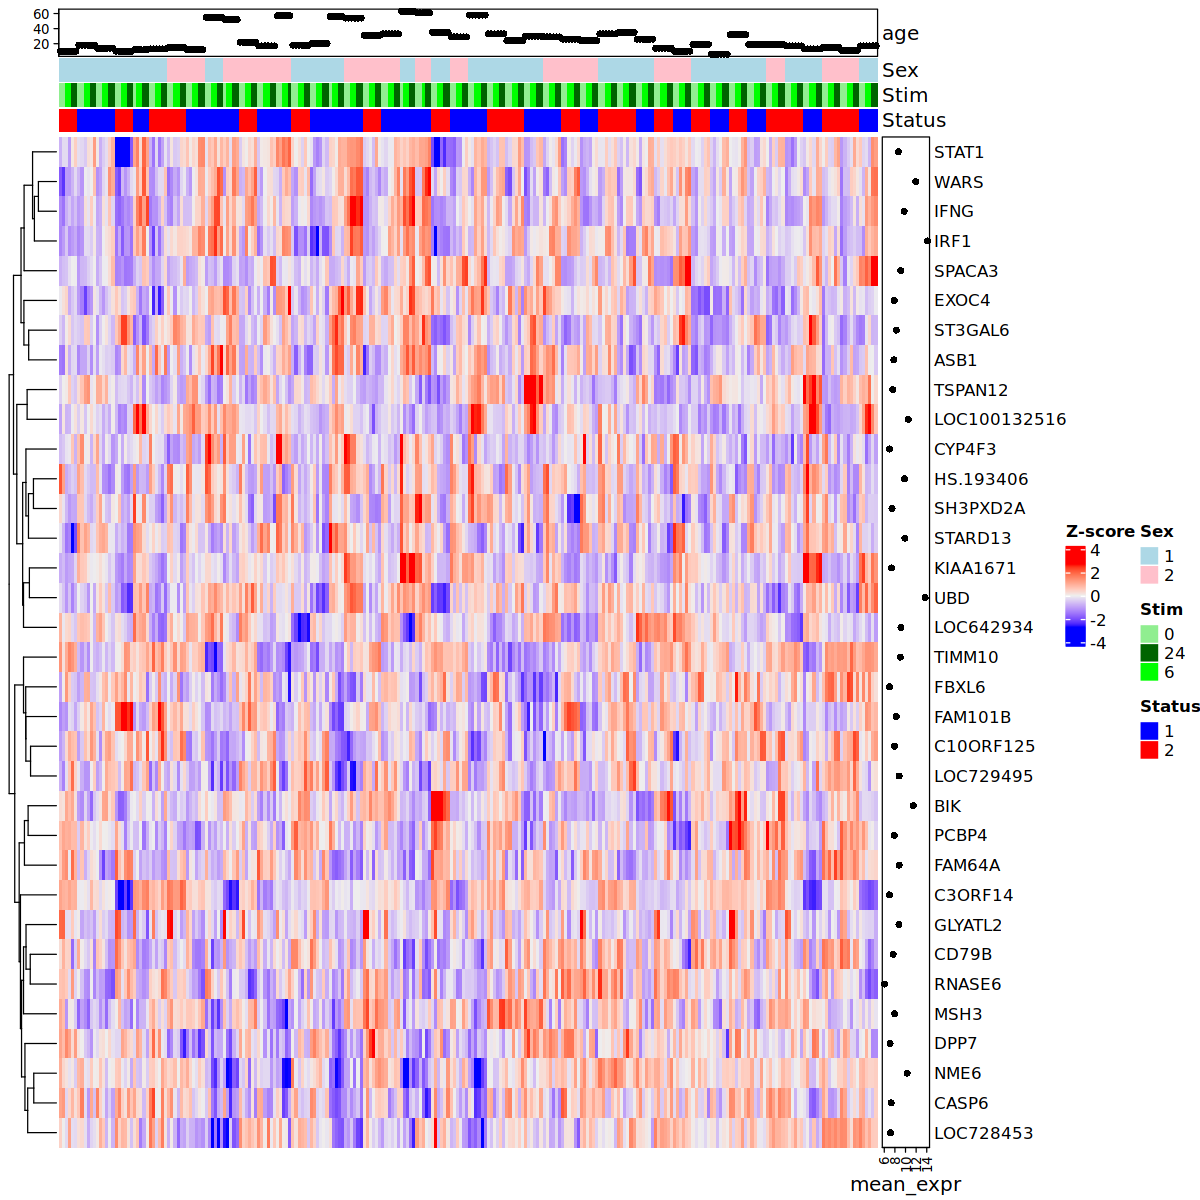

In [25]:
# Code cell n°18
h_tmat_full <- ComplexHeatmap::Heatmap(tmat_full,
                                name = "Z-score",
                                top_annotation = ha_col,
                                right_annotation = ha_row,
                                row_names_gp = gpar(fontsize = 10),
                                cluster_columns = FALSE)

ComplexHeatmap::draw(h_tmat_full)

=> There are many more possibilities with ComplexHeatmap, for example to play with color gradient, to display dendograms with different colors, to split the heatmap with the clusters, to draw heatmaps next to each other in a composite plot... Just refer to its [guide](https://jokergoo.github.io/ComplexHeatmap-reference/book/)!

***Note:*** You could also try to play with two other packages to draw **interactive heatmaps**:
- [`InteractiveComplexHeatmap`](https://github.com/jokergoo/InteractiveComplexHeatmap)
- [`heatmaply`](https://cran.r-project.org/web/packages/heatmaply/vignettes/heatmaply.html) as explained in this short [tutorial](https://www.datanovia.com/en/fr/blog/comment-creer-une-superbe-heatmap-interactive-dans-r/).<br>
*They were not installed on adenine*.

<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to draw annotated heatmaps. 
</div>
    

## 3. Enrichment analysis with `clusterProfiler`
---

There are two main packages to study gene sets enrichment in R.

- [gprofiler2](https://cran.r-project.org/web/packages/gprofiler2/index.html): a CRAN packages to do similar analyses as in the web interface of [G:Profiler](https://biit.cs.ut.ee/gprofiler/gost)

- [clusterProfiler](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) available in Bioconductor.

**clusterProfiler** is by far the most complete and flexible tool to perform ORAs (Over-Representation Analyses) that are single-gene enrichment methods, or to perform SAFE (Significance Analysis of Function and Expression) like GSEA.

Its guide is available at both these links:
- https://bioconductor.org/packages/release/bioc/vignettes/clusterProfiler/inst/doc/clusterProfiler.html
- https://yulab-smu.top/biomedical-knowledge-mining-book/index.html

### 3.1. ORA

**clusterProfiler** can be used for several ORAs on different datasets: Gene Ontology (GO), Kyoto Encyclopedia of Genes and Genomes (KEGG), Reactome, Disease Ontology (DO), Disease Gene Network (DisGeNET), wikiPathways, Molecular Signatures Database (MSigDb) and custom datasets.

We will illustrate clusterProfiler usage on GO, Reactome and KEGG.

#### 3.1.A. GO

clusterProfiler needs **a set of unique genes**.

In [ ]:
# Code cell n°19

mygenes <- unique(row.names(mat_full)) 

The function to run it for GO ebrichment is `enrichGO()`. For the `ont` (Ontology) argument, we can specify either molecular function ("MF"), cellular components ("CC"), biological processes ("BP") or "ALL".

Here we use `org.Hs.eg.db` as the database collecting all genes for the human genome with their different identifiers. This database is available in a bioconductor package: https://bioconductor.org/packages/release/data/annotation/html/org.Hs.eg.db.html

<div class="alert alert-block alert-danger"><b>Caution:</b> 
When performing enrichment analyses, you should not run the analysis againts all genes in the genome, but only on the subset of expressed genes in your samples. We call it the <b> universe</b>. Here we select all unique expressed genes.
<br>
For the `keyType` in GO enrichment, we can use the genes SYMBOL rather than the ENSEMBL or ENTREZID.
    
The `minGSize` and `maxGsize` are parameters to set up the min and max of number of genes to be part of a gene set to be tested.   
Finally, we select statistical parameters: a pvalueCutoff after an adjustment for multiple testing.
</div>    

In [ ]:
# Code cell n°20

enr_go <- enrichGO(gene = mygenes, 
             ont ="ALL", 
             OrgDb = org.Hs.eg.db,
             universe = unique(probes$TargetID),
             keyType = "SYMBOL", 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.1, 
             pAdjustMethod = "BH")

<mark> Be patient, the above command can last a minute or so </mark>

We can visualize for example to top 20 enrichments:

In [ ]:
# Code cell n°21
head(enr_go, 20)

**Several nice plots can be drawn** as described in Chapter 15 of the manual: http://yulab-smu.top/biomedical-knowledge-mining-book/enrichplot.html.

Among available plots, we can draw:

- **barplots** is the most widely used vizualization. It depict the enrichment scores (e.g. p values) and gene counts or ratio as bars whose length and color are proportional to the number of enriched genes.

In [ ]:
# Code cell n°22
options(repr.plot.width = 12, repr.plot.height = 7)
barplot(enr_go, showCategory = 20,
        label_format = function(x) stringr::str_wrap(x, width = 120)) + #to be able to see terms description in a single row : play on the number (eg. 120)
        ggtitle("dotplot for ORA") ## uses ggplot2 you will see in session 4

- **dotplots** that depict the enrichment scores (e.g. p values) and gene counts or ratio as dots whose size is proportional to the number of enriched genes. By default they are sorted by incerasing p adjust pvalue.

In [ ]:
# Code cell n°23
options(repr.plot.width = 12, repr.plot.height = 7)
dotplot(enr_go,
        showCategory=20,
        label_format = function(x) stringr::str_wrap(x, width=  120)) +
        ggtitle("dotplot for ORA")

- **emapplots (enrichment map plots)**: Enrichment map organizes enriched terms into a network with edges connecting overlapping gene sets. In this way, mutually overlapping gene sets tend to cluster together, making it easy to identify functional module.

In [ ]:
# Code cell n°24
options(repr.plot.width = 30, repr.plot.height= 10)
enr_go <- enrichplot::pairwise_termsim(enr_go, method = "JC", semData = "org.Hs.eg.db")
emapplot(enr_go, showCategory = 20)

<mark> Do not hesitate to rerun the above command if the figure displayed is not readable. The layout changes every time it is run.</mark>

- **treeplots**: displays a hierarchical clustering of enriched terms (after pairwise step in previous cell)

In [ ]:
# Code cell n°25
options(repr.plot.width = 30, repr.plot.height = 15)
treeplot(enr_go,
         hclust_method = "average")

- **upsetplots**: displays the association between genes and gene sets. It emphasizes the gene overlapping among different gene sets.

In [ ]:
# Code cell n°26
upsetplot(enr_go)

- **cne plots**: depict the linkages of genes and biological concepts (e.g. GO terms or KEGG pathways) as a network.

One plot often generated like the upsetplot is the cnetplot that depicts the linkages of genes and biological concepts (e.g. GO terms or KEGG pathways) as a network.

For some reason, it fails in this version of clusterProfiler installed on the environment and we cannot update it because the last version uses a newer R version. But below is the command to use that should work on your computer and a picture of what you should obtain.

`cnetplot(enr_go, categorySize="pvalue", showCategory = 5)`

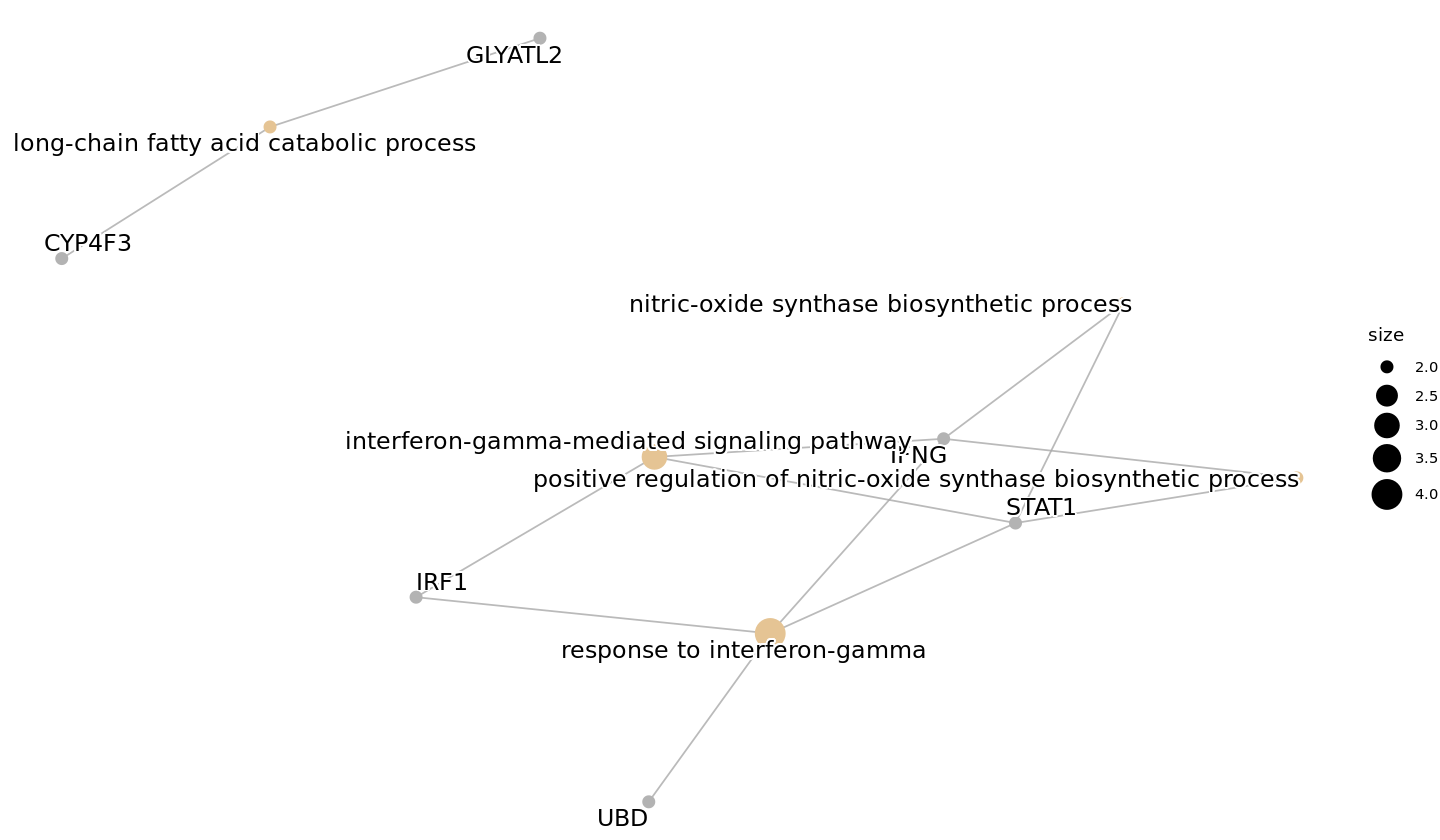

There are many more plots available. The package clusterProfiler is in constant development with new plots. 

#### 3.1.B. Reactome

Similarly, we can run the ORA on Reactome pathways. It uses the gene IDs rather than the gene symbols. So we have to get them.

In [ ]:
# Code cell n°27

geneID_sig <- subset(limma.full.outs$limma.fullmodel.out, adj.P.Val < 0.01 )[, "ENTREZ_GENE_ID"]
length(geneID_sig)

In [ ]:
# Code cell n°28

enr_react <- enrichPathway(gene = geneID_sig, pvalueCutoff = 0.10, readable = TRUE)
head(enr_react)

You can draw any figures as above.

In [ ]:
# Code cell n°29

options(repr.plot.width = 12, repr.plot.height = 7)
dotplot(enr_react,
        showCategory = 20,
        label_format = function(x) stringr::str_wrap(x, width=  120)) +
        ggtitle("dotplot for ORA")

#### 3.1.C. KEGG

Similarly, we can run the ORA on KEGG pathways. The trick here is not to use gene name symbols, nor Gene IDs but their matching Uniprot IDs. The function `bitr()` generates the correspondance when available.

In [ ]:
# Code cell n°30

mygenes2 <- clusterProfiler::bitr(mygenes, fromType = 'SYMBOL', toType = 'UNIPROT', OrgDb = 'org.Hs.eg.db')
mygenes2

As you can see, several UniprotIDs may exist for a given gene.

In [ ]:
# Code cell n°31
table(mygenes2$SYMBOL)

Thus, duplicated IDs must be removed if any UNIPROT IDs taken.

In [ ]:
# Code cell n°32

mygenes2 <- mygenes2[!duplicated(mygenes2$SYMBOL), ]
mygenes2
mygeneList2 <-mygenes2$UNIPROT
mygeneList2

You do the same gene SYMBOL to UNIPROT conversion for the universe:

In [ ]:
# Code cell n°33

prot_universe <- unique(probes$TargetID)
prot_universe <- clusterProfiler::bitr(prot_universe, fromType = 'SYMBOL', toType = 'UNIPROT', OrgDb = 'org.Hs.eg.db')
prot_universe <- prot_universe[!duplicated(prot_universe$SYMBOL), ]
prot_universe <- prot_universe$UNIPROT

You are now ready for the enrichment analysis on KEGG.

Unfortunately, the installed version of clusterProfiler in adenine is no longer able to run it and we cannot update it to a newer version which is based on R 4.2.0. But we put the commands below and an image of the expected results. On you personnal computer, it whould work.

<code>enr_kegg <- enrichKEGG(gene = mygeneList2,
             keyType = "uniprot",
             minGSSize = 3,
             maxGSSize = 800,
             pvalueCutoff = 0.10,
             universe = prot_universe,
             organism = "hsa",
             pAdjustMethod = "none")</code>

<code>dotplot(enr_kegg)</code>

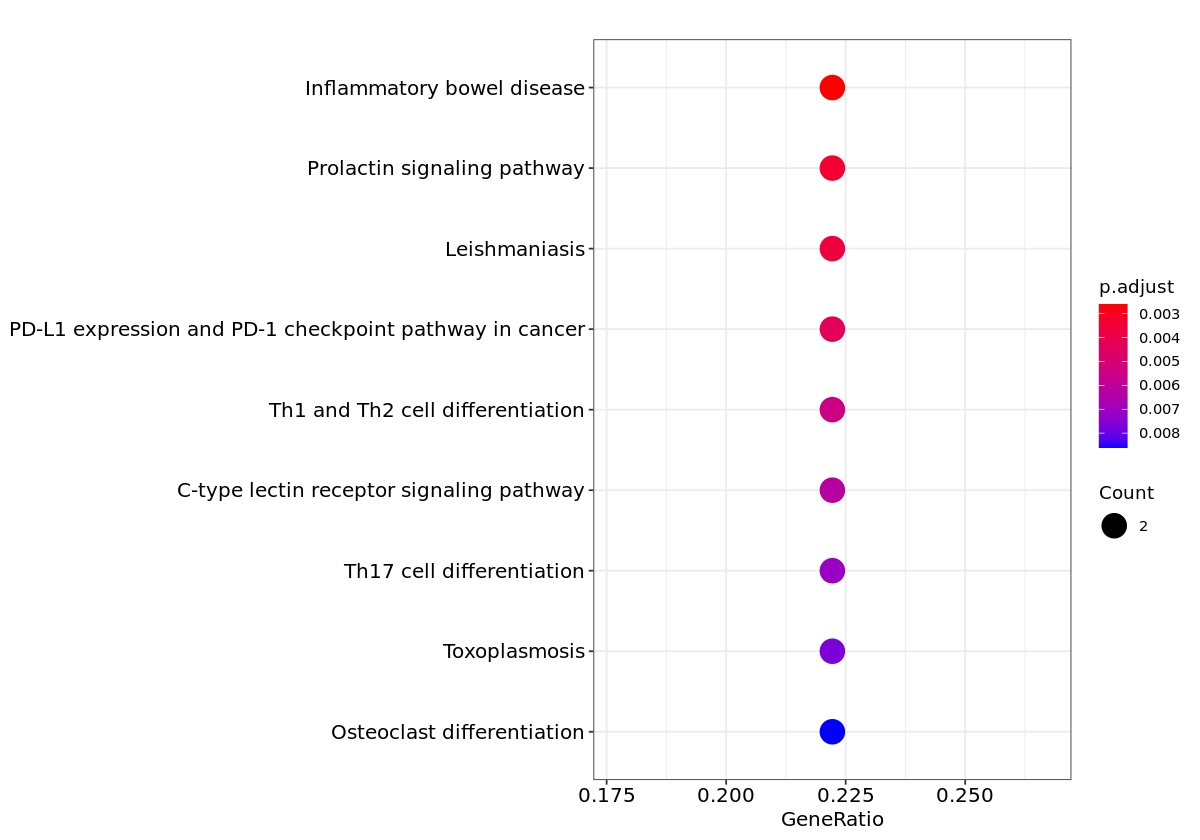

<code>enr_kegg <- pairwise_termsim(enr_kegg, method = "JC", semData = "org.Hs.eg.db")
emapplot(enr_kegg)</code>

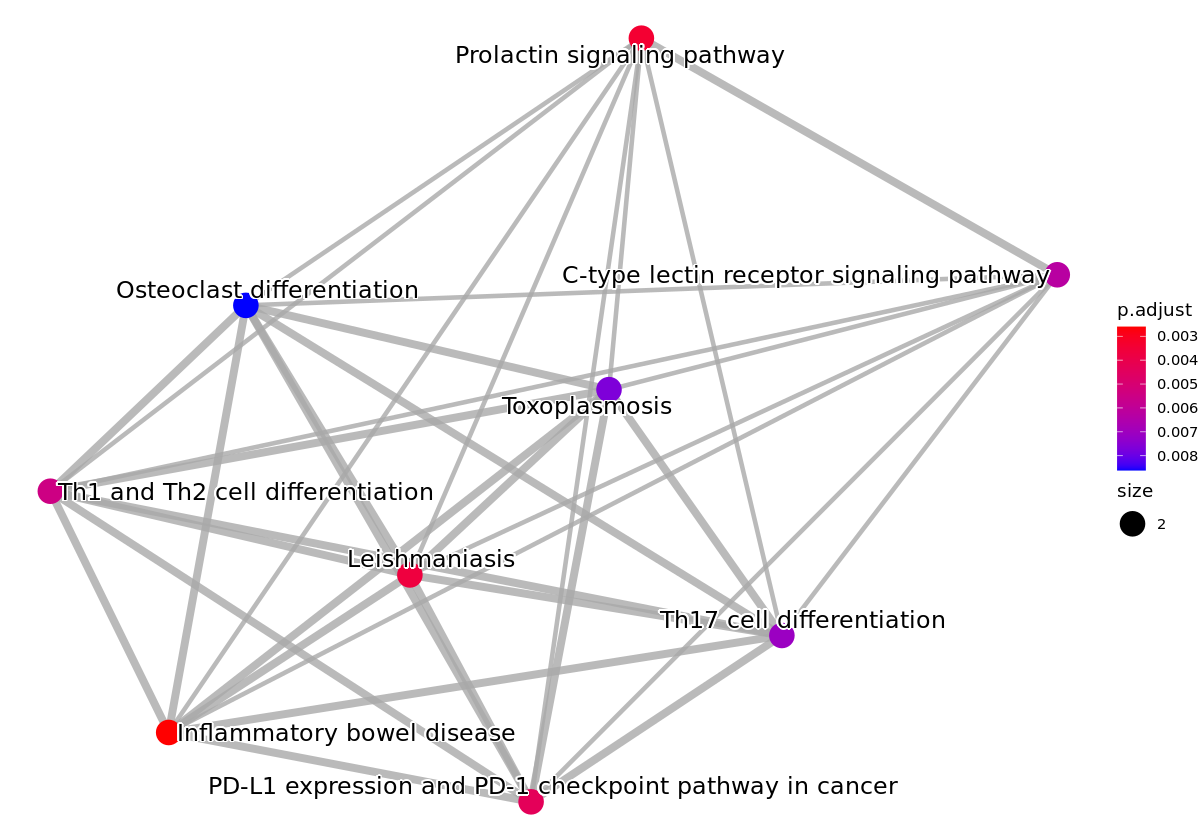

<code>enr_kegg2 <- setReadable(enr_kegg, OrgDb = "org.Hs.eg.db", "UNIPROT")
cnetplot(enr_kegg2, categorySize="pvalue", showCategory = 5)</code>

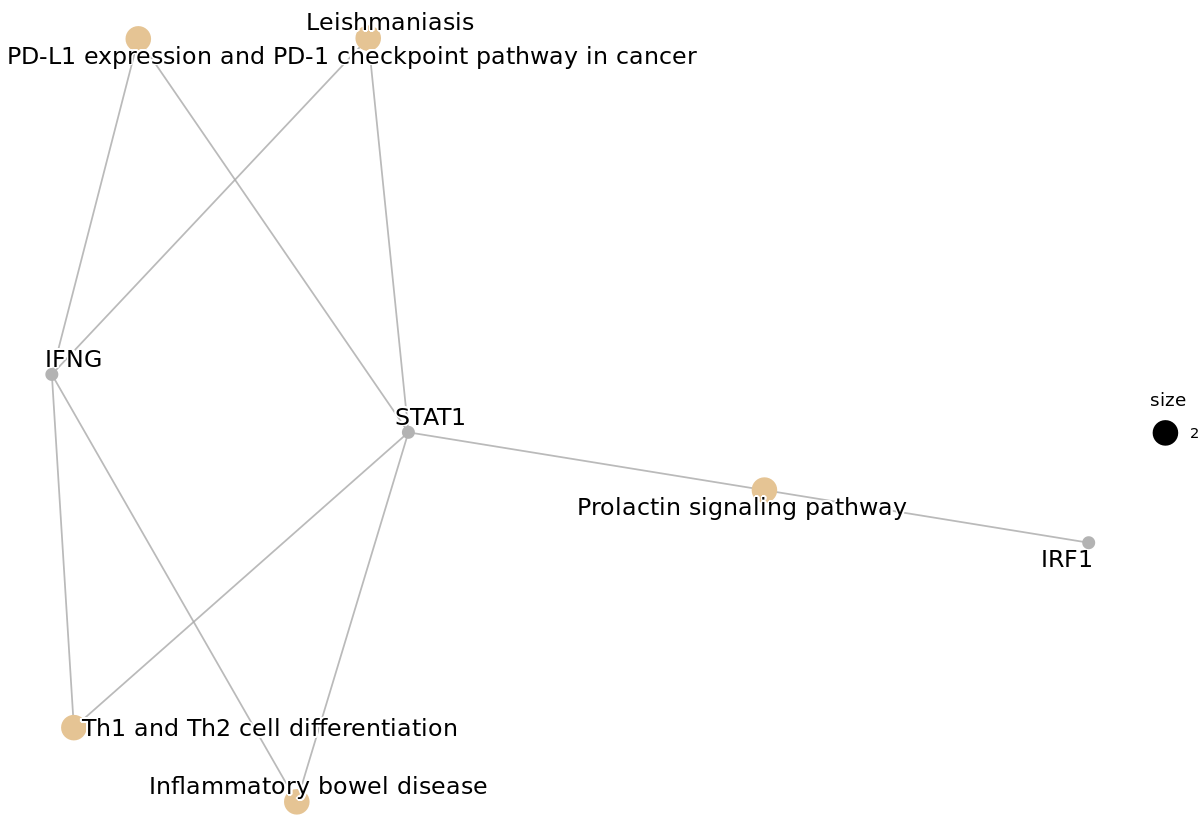

### 3.2. GSEA

GSEA, standing for Gene Set Enrichment Analysis, is a Significance Analysis of Function and Expression (SAFE) method. While ORAs (over-representation methods) are single-gene approaches, GSEA uses all genes in the dataset and their potential correlation. In addition, it uses quantitative metrics like gene expression or statistics results from a DGE analysis. This later is the most recommended approach to follow.

[GSEA](https://www.gsea-msigdb.org/gsea/index.jsp) was developped at the Broad Institue. The documentation is available [here](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html). It was described in [Subramanian et al. 2005](https://doi.org/10.1073/pnas.0506580102)


Finally we can run a Gene Set Enrichment Aanalysis (GSEA) directly with clusterProfiler. We need first to sort genes by a quantitative metrics, here the statistics of the DGE analysis.


We do it here for example with the Pat versus Control DGE results on GO terms.

In [ ]:
# Code cell n°34

mygenes <- limma.full.outs[[6]]$B
names(mygenes) <- limma.full.outs[[6]]$TargetID
mygenes <- sort(mygenes, decreasing = T) 
head(mygenes)

In [ ]:
# Code cell n°35

gsea_go <- gseGO(geneList = mygenes, 
             ont ="ALL", 
             keyType = "SYMBOL",
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.25, 
             verbose = TRUE, 
             OrgDb = org.Hs.eg.db, 
             pAdjustMethod = "none",
                 nPerm = 100)    # by default there are 1000 permutations

<mark> It may take a long time and use a lot of memory due to permutations.</mark>

Let's see the result of the top enriched pathway.

In [ ]:
# Code cell n°36

gseaplot2(gsea_go, geneSetID = 1, title = gsea_go$Description[1])

We can also display several patways on the same plot.

In [ ]:
# Code cell n°37

gseaplot2(gsea_go, geneSetID = 1:3, title = "top 3 gene sets", pvalue_table = TRUE,
          color = c("#E495A5", "#86B875", "#7DB0DD"), ES_geom = "dot")

We can also look at the usual figures implemented in clusterProfiler, such as dotplots :

In [ ]:
# Code cell n°38

options(repr.plot.width = 17, repr.plot.height = 10)
dotplot(gsea_go, showCategory=20,
        label_format = function(x) stringr::str_wrap(x, width=  120))+
        ggtitle("dotplot for GSEA")

or emmaplots:

In [ ]:
# Code cell n°39

options(repr.plot.width = 12, repr.plot.height = 7)

gsea_go <- enrichplot::pairwise_termsim(gsea_go, method = "JC", semData = "org.Hs.eg.db")
emapplot(gsea_go, showCategory = 20)

or the cneplots :

Here again, we provide you the commands and results but it does not run on this clusterProfiler version.

<code>options(repr.plot.width=8, repr.plot.height= 8)
    cnetplot(gsea_go, categorySize="pvalue", showCategory = 5)</code>

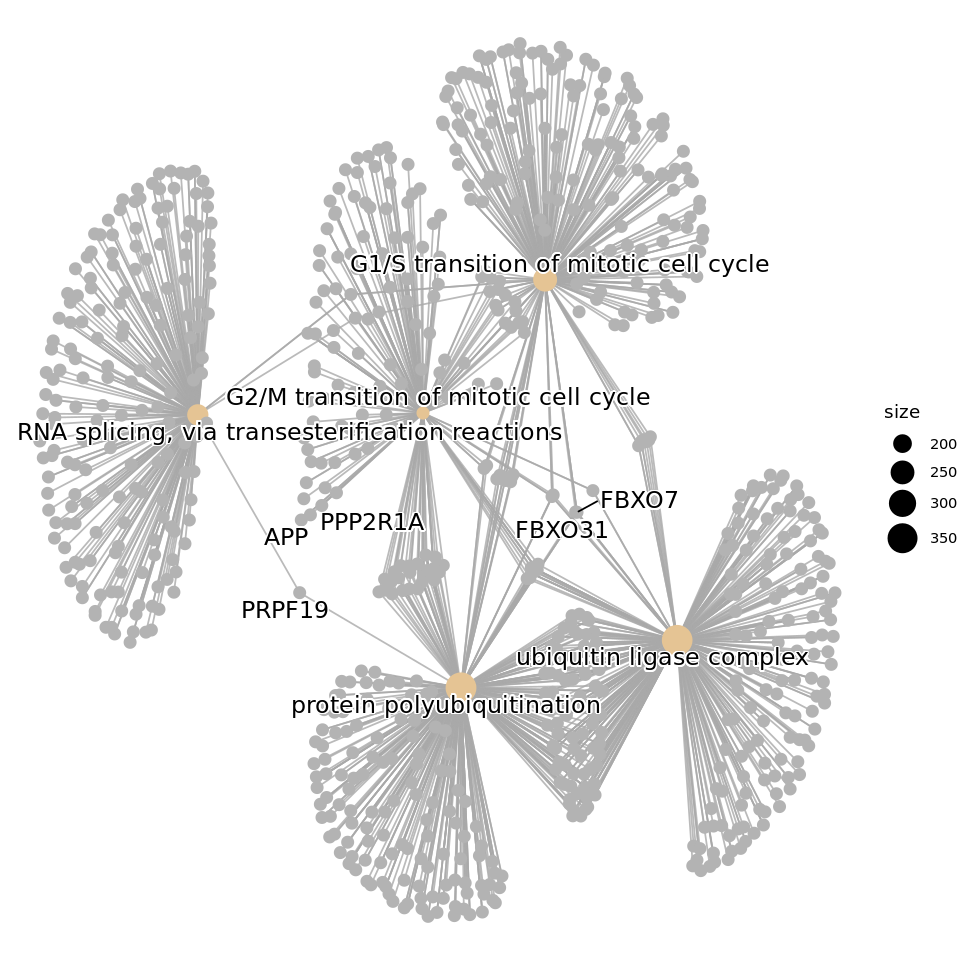


The size of the plot can impact the figure: see the same figure with higher height!

<code>options(repr.plot.width = 13, repr.plot.height = 13)
cnetplot(gsea_go, categorySize="pvalue", showCategory = 5)</code>

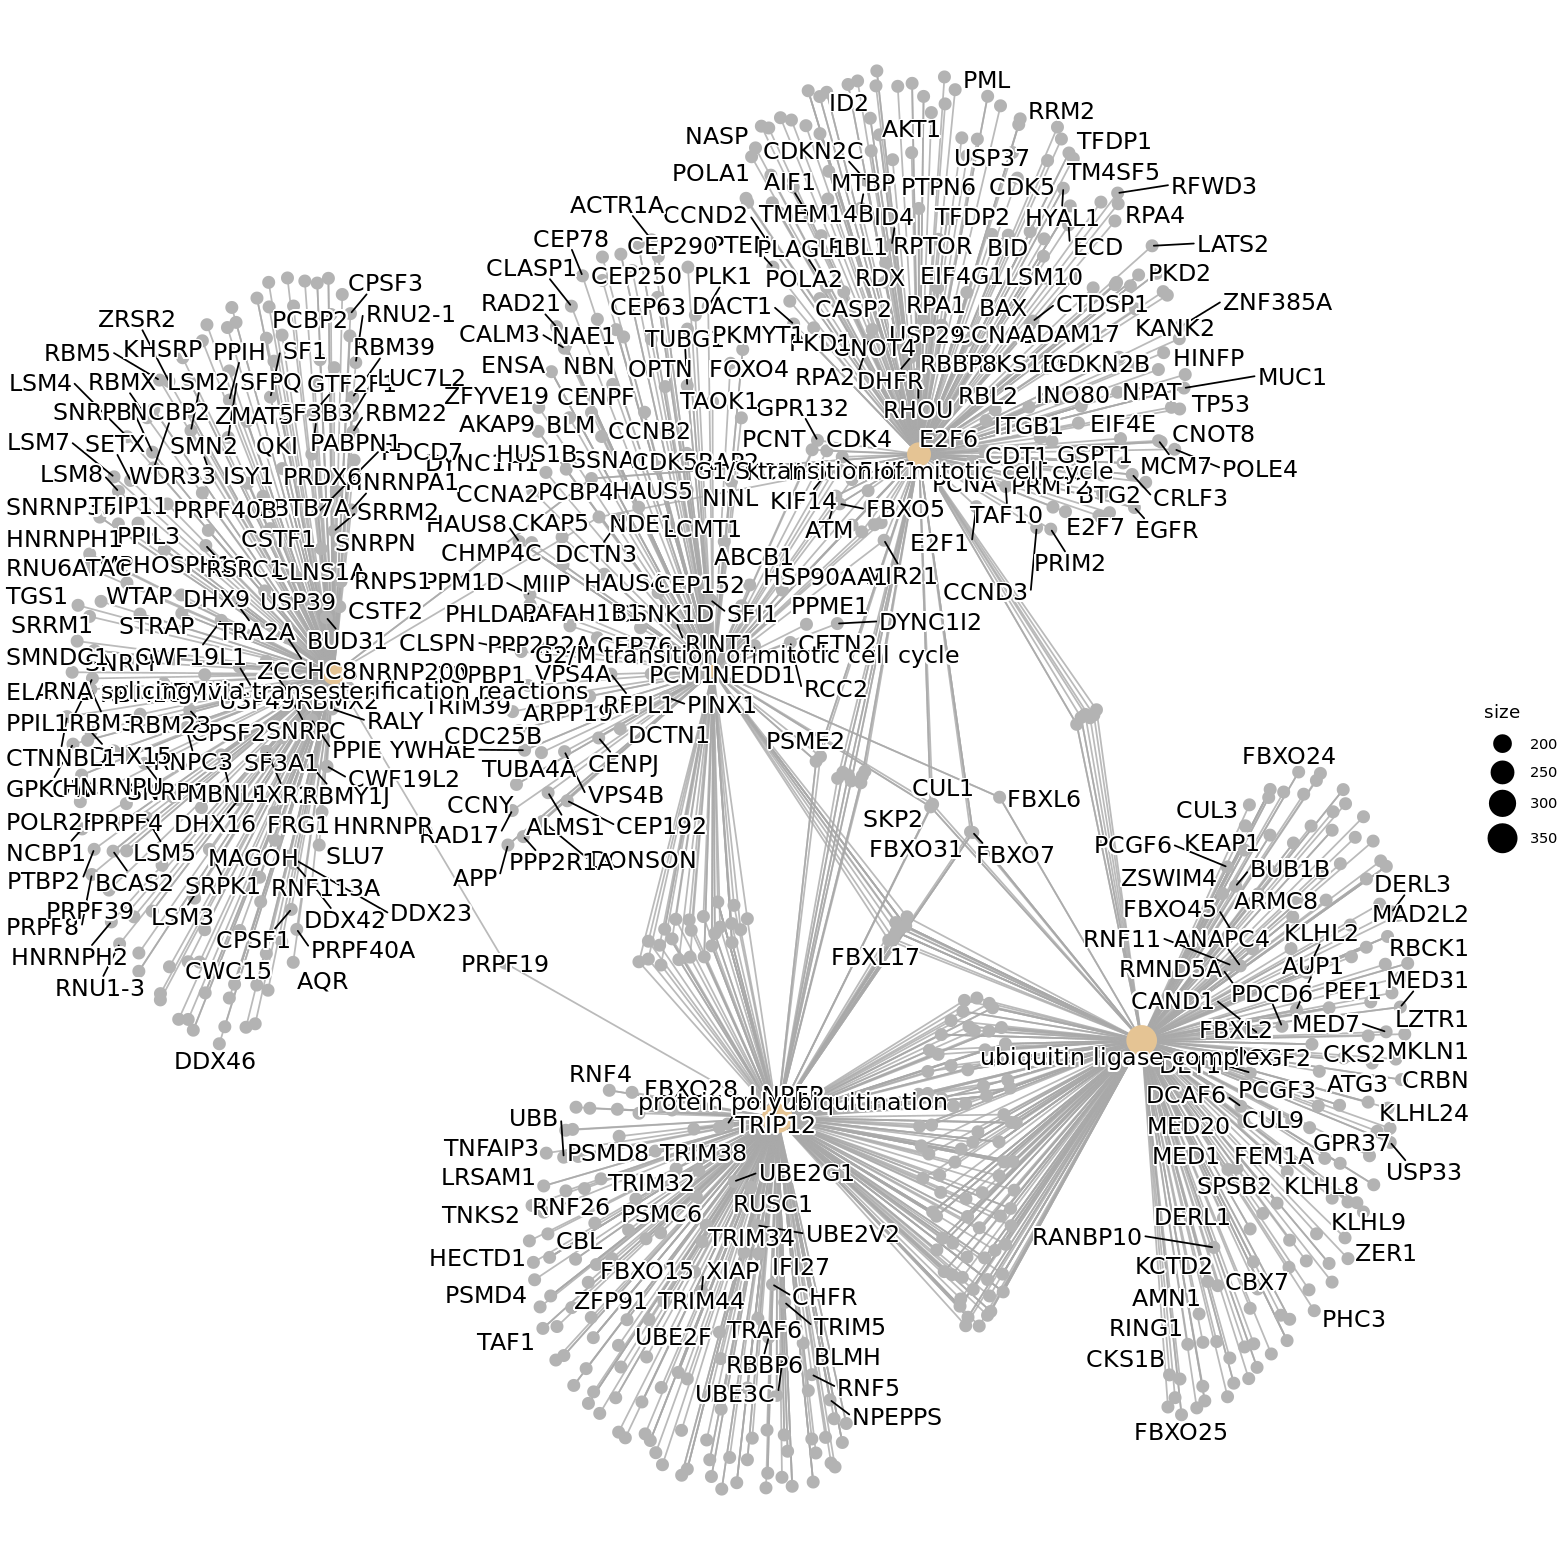

We can also use the **ridgeplot** format which visualizes expression distributions of core enriched genes for GSEA enriched categories. It helps users to interpret up/down-regulated pathways.

In [ ]:
# Code cell n°40

options(repr.plot.width = 30, repr.plot.height = 7)
ridgeplot(gsea_go, label_format = function(x) stringr::str_wrap(x, width=  120))

The x axis is the log2(FC) distribution of genes in pathways. Here all enriched pathways are downregulated!

## 4. GSEA with the Java application:

### 4.1. Preparing input files

The GSEA Java application is a stand-alone software to run GSEA on your own computer. 

**Two GSEA methods** are implemented in the Java application:
1. with unranked expression data: GSEA will cluster genes by similarity (different metrics/methods can be used).
2. with pre-ranked expression data: this method is the recommended one. After DGE analysis, we usually upload the data ranked by the statistics, or (and this is equivalent) ranked by the signed pvalue (meaning a positive pvalue when the fold change is positive, a negative pvalue when the fold change is negative).

Whatever the method used, GSEA can only compare two conditions.

GSEA requires **two input files:**
- an expression file
- a phenotype file

***The format for the different inputs is described [here](https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats)***

#### 4.1.A. Expression files:

There are 4 acceptable formats for expression input files: `.gct`, `.res`, `.pcl` and `.txt`. Here we will prepare files in `.txt` format with R. It requires to fill a first column `NAMES` with the names of the genes/probes, followed by a column `DESCRIPTION` that must be with `NA` values (a bug in GSEA requires this column although it is not informative; they will try to fix this issue in a future release), then a column for each sample.

- if we start from normalised unranked values:

We use the `norm.quant` object.

In [ ]:
# Code cell n°41

gsea_T1D_norm.quant <- data.frame("NAMES" = row.names(norm.quant), "DESCRIPTION" = NA, as.data.frame(norm.quant))
names(gsea_T1D_norm.quant)[-(1:2)] <- samples_info$array.labels
str(gsea_T1D_norm.quant)
write.table(gsea_T1D_norm.quant, file="gsea_T1D_norm.quant.txt", sep="\t", col.names = TRUE, quote = FALSE, row.names = FALSE)

- if we start from preranked values: using the signed pvalues

The format is RNK: Ranked list file format (`*.rnk`) 
Here are the command for the 5th contrast as an example. You can do the same for other constrats.

In [ ]:
# Code cell n°42

gsea_T1D_PatVsCont <- data.frame(limma.full.outs[[6]]$ProbeID, limma.full.outs[[6]]$B)
write.table(gsea_T1D_PatVsCont, file="gsea_T1D_PatVsCont.rnk", sep="\t", col.names = FALSE, quote = FALSE, row.names = FALSE)

#### 4.1.B. Phenotype files:

The format `.cls` format is the one for phenotypes.

1. On the first line, you specify 3 values separated by spaces:
- the number of samples
- the number of classes (or levels of your factor of interest)
- 1: always, don't change it

2. On the second line, you put names for each class as they will appear in analysis report. The line should begin with a hashtag sign (#) followed by a space.

3. The third line contains a class label for each sample. The class label can be the class name, a number, or a text string. The first label used is assigned to the first class named on the second line; the second unique label is assigned to the second class named; and so on. The number of class labels specified on this line should be the same as the number of samples specified in the first line. The number of unique class labels specified on this line should be the same as the number of classes specified in the first line.

Here, we will prepare two phenotype files.

- You can prepare one phenotype file per contrast of interest as for example between patients and controls (whathever the stimulus):

In [ ]:
# Code cell n°43

temp <- samples_info$Status
temp <- ifelse(temp == 2, "PAT", "CONT")
gsea_pheno_PatVsCont <- file("gsea_pheno_PatVsCont.cls")
my_text <- paste("264 2 1\n#PAT CONT\n", paste(temp, collapse=" "))
writeLines(my_text, gsea_pheno_PatVsCont)
close(gsea_pheno_PatVsCont)
rm(temp)

You should see the `gsea_pheno_PatVsCont` file in the left column. Open it to see its structure.

- You can also prepare a phenotype file with all groups depending on status and stimulus: g.1.0, g.1.6, g.1.24, g.2.0, g.2.6, g.2.24:

In [ ]:
# Code cell n°44

str(samples_info)

In [ ]:
# Code cell n°45

temp <- samples_info$Status
temp <- ifelse(temp == 2, "PAT", "CONT")
temp <- paste(temp, samples_info$Stim, sep = "")
temp

In [ ]:
# Code cell n°46

gsea_pheno_groups <- file("gsea_pheno_groups.cls")
my_text <- paste("264 6 1\n#PAT0 PAT6 PAT24 CONT0 CONT6 CONT24\n", paste(temp, collapse=" "))
writeLines(my_text, gsea_pheno_PatVsCont)
close(gsea_pheno_groups)

### 4.2. Running GSEA (Java Stand-Alone Application)

You are ready to run your first GSEA analyses!

Download the Java application from [here](http://www.gsea-msigdb.org/gsea/downloads.jsp) with the appropriate version for your OS. Unzip the downloaded file and launch GSEA by double-clicking on `gsea.bat` if you are on Windows, by double-clicking on the App or on the `gsea.command` if you are on macOS, or by typing the command `./gsea.sh` if you are on Linux or on macOS.

In File>Preferences, specify the directoty where you want the GSEA results to be saved. By default it is in your home repository `/gsea_home/output`.

Click on `Load Data` and upload the different input files. No error must be reported if your formats are correct.

#### <u>4.2.A. If you are using the **method with unranked values**:</u>

- Click on **Run GSEA**

- Select the correct in **Required fields** the correct filed and parameters:
    - `gsea_T1D_norm.quant.txt` for the expression dataset
    - choose the gene set database of interest
    - start with keeping 1000 permutations: if you have pvalues displayed at 0, then rerun the analysis increasing the number of permutations
    - for phenotype labels, select one of the `.cls` file and the contrast of interest
    - keep the option `collapse` to deal with several probes for the same gene
    - choose `phenotype` for permutation if you have several samples per category (7 are recommanded), otherwise select `gene_set` but the statistical test will not be able to account for putative correlations between genes.
    - select here `Human_ILLUMINA_Array_MSigDB.v2022.1.Hs.chip` since we are working with Illumina array data and we kept the probeID identifiers. Should you be working with unique gene symbols, select the `HGNC` platform.<br>
<br>
- In **Basic fields** enter a useful name for your analysis and select a method to rank genes. You can also specify the output folder name.

- Click on **Run** at the bottom.

- You can then run a **Leading edge** analysis and vizualize enrichment map. The enrichment outputs can also be imported to `Cytoscape` using the Cytoscape app `EnrichmentMap`.
    
#### <u>4.2.B. If you are using the **method with pre-ranked values**:</u>

- Click on **Run GSEAPreranked**

- Select in **Required fileds** the correct files and parameters:<br>
    - choose the gene set database of interest
    - start with keeping 1000 permutations: if you have pvalues displayed at 0, then rerun the analysis by increasing the number of permutations
    - for the ranked list, select for example `gsea_T1D_PatVsCont.rbk`
    - keep the option `collapse` to deal with several probes for the same gene
    - select here `Human_ILLUMINA_Array_MSigDB.v2022.1.Hs.chip` since we are working with Illumina array data and we kept the probeID identifiers. Should you be working with unique gene symbols, select the `HGNC` platform.<br>
<br>
- In **Basic fields** enter a useful name for your analysis and select a method to rank genes. You can also specify the output folder name.


<div class="alert alert-block alert-success"><b>Well done:</b>
If your analysis was succesfull, you see <code>Success</code> in green in the "GSEA Reports" frame on the left panel.  Just click on <code>Success</code> to look at the results. Follow the <a href=https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html>guide</a> to understand the outputs. A FDR of 25% is the minimum required to consider a significant enrichment.
</div>

>***Note: GSEA in R:***
>- an R package exist to run GSEA: [GSEABase](https://bioconductor.org/packages/release/bioc/html/GSEABase.html)
>- the package clusterProfiler implements GSEA (see part 3.2 of this tutorial) and even a fastest approach (fgsea).

---
---

<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to draw annotated heatmaps and perform enrichment analyses, either ORAs or GSEAs. 
</div>
    

<div class="alert alert-block alert-info"><b> What can you try by yourself?</b>
Here are some ideas:<br>
- try to redo the analyses with other DGE outputs: above we used either the full model or one contrast only.<br>
- try other cutoffs for significant genes and redo the analyses<br>
- try other parameters for the clustering: in the heatmaps, or in GSEA Java application.<br>
- try other packages for clustering, heatmaps or enrichment analyses<br>
- try other clustering methods like kmeans<br>
- try other integrative approaches like WGCNA<br>
</div>

[version 13/11/2022 - last revision:@SCaburet]